In [51]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn
from lxml import html
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Получаем 250 самых топовых фильмов

In [19]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

Парсим страницу с фильмами и получаем грязные данные с


1.   Названием фильма
2.   Рейтингом
3.   Командой 
4.   Ссылкой на основную страницу




In [20]:
movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

In [21]:
data_frame = {
    "movies": movies,
    "ratings": ratings,
    "crew": crew,
    "links": links
}

data = pd.DataFrame(data_frame)
data

,movies,ratings,crew,links
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.239990361473694,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.160997117810007,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993872535873475,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.99010819442431,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950785755799387,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/
...,...,...,...,...
245,"[\n 246.\n , [Красавица и чудовище],...",8.01663851953185,"Gary Trousdale (dir.), Paige O'Hara, Robby Benson",/title/tt0101414/
246,"[\n 247.\n , [Ганди], \n, [(1982)], \n]",8.015339636591271,"Richard Attenborough (dir.), Ben Kingsley, Joh...",/title/tt0083987/
247,"[\n 248.\n , [Прислуга], \n, [(2011)...",8.014439636681775,"Tate Taylor (dir.), Emma Stone, Viola Davis",/title/tt1454029/
248,"[\n 249.\n , [Служанка], \n, [(2016)...",8.012729574223776,"Park Chan-wook (dir.), Kim Min-hee, Ha Jung-woo",/title/tt4016934/


Несколько функциий для преобзразования грязных заголовков с названием фильмов


In [22]:
def process_text_mv(text):
    data = text.get_text().split("\n")
    return data[2].strip()

In [23]:
def process_text_year(text):
    data = text.get_text().split("\n")
    return data[3].strip()[1:-1]

In [24]:
data["title"] = data.movies.apply(process_text_mv)
data["year"] = data.movies.apply(process_text_year)

In [25]:
data.head()

,movies,ratings,crew,links,title,year
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.239990361473694,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.160997117810007,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993872535873475,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.99010819442431,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950785755799387,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957


In [26]:
data.crew[1]

'Francis Ford Coppola (dir.), Marlon Brando, Al Pacino'

Задача 1.
Получить список всех участников команд (убрать постфикс `(dir.)` у директоров). Найти количество уникальных имен. 

In [27]:
all_names = []

for s in data.crew.values:
    for name in s.replace(" (dir.)", "").split(", "):
        all_names.append(name)
    
print(f"Number of all unique names: {len(set(all_names))}")
print(f"Examples: {all_names[:6]}")

Number of all unique names: 526
Examples: ['Frank Darabont', 'Tim Robbins', 'Morgan Freeman', 'Francis Ford Coppola', 'Marlon Brando', 'Al Pacino']


Задача 2.
Получить список всех директоров. Построить распределение (визуализация обязательна) и найти директора(ов), у которого(ых) больше всего фильмов в топе.

In [28]:
all_dirs = {}

for s in data.crew.values:
    for name in s.split(", "):
        if name.endswith(" (dir.)"):
            if name in all_dirs:
                all_dirs[name] += 1
            else:
                all_dirs[name] = 1

all_dirs_list = sorted([(k, v) for k, v in all_dirs.items()], key=lambda x: -x[1])
print(all_dirs_list)

dirs = [x[0] for x in all_dirs_list[:20]]
num_films = [x[1] for x in all_dirs_list[:20]]

[('Christopher Nolan (dir.)', 7), ('Steven Spielberg (dir.)', 7), ('Martin Scorsese (dir.)', 7), ('Akira Kurosawa (dir.)', 7), ('Stanley Kubrick (dir.)', 7), ('Alfred Hitchcock (dir.)', 6), ('Quentin Tarantino (dir.)', 5), ('Charles Chaplin (dir.)', 5), ('Billy Wilder (dir.)', 5), ('Sergio Leone (dir.)', 4), ('Hayao Miyazaki (dir.)', 4), ('Francis Ford Coppola (dir.)', 3), ('Peter Jackson (dir.)', 3), ('David Fincher (dir.)', 3), ('Frank Capra (dir.)', 3), ('James Cameron (dir.)', 3), ('Ridley Scott (dir.)', 3), ('Pete Docter (dir.)', 3), ('Denis Villeneuve (dir.)', 3), ('Clint Eastwood (dir.)', 3), ('Ingmar Bergman (dir.)', 3), ('Frank Darabont (dir.)', 2), ('Sidney Lumet (dir.)', 2), ('Robert Zemeckis (dir.)', 2), ('Milos Forman (dir.)', 2), ('Roman Polanski (dir.)', 2), ('Bong Joon Ho (dir.)', 2), ('Andrew Stanton (dir.)', 2), ('Anthony Russo (dir.)', 2), ('Sam Mendes (dir.)', 2), ('Park Chan-wook (dir.)', 2), ('Mel Gibson (dir.)', 2), ('Lee Unkrich (dir.)', 2), ('David Lean (dir.)'

<BarContainer object of 7 artists>

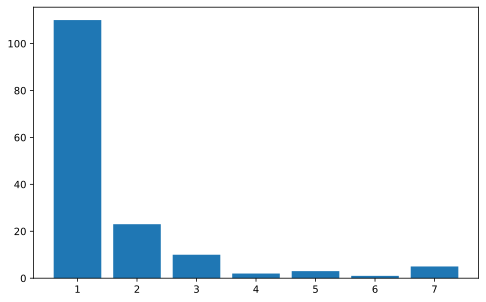

In [29]:
distr = {}

for k, v in all_dirs.items():
    if v in distr:
        distr[v] += 1
    else:
        distr[v] = 1

plt.bar(distr.keys(), distr.values())

Text(0, 0.5, 'num films')

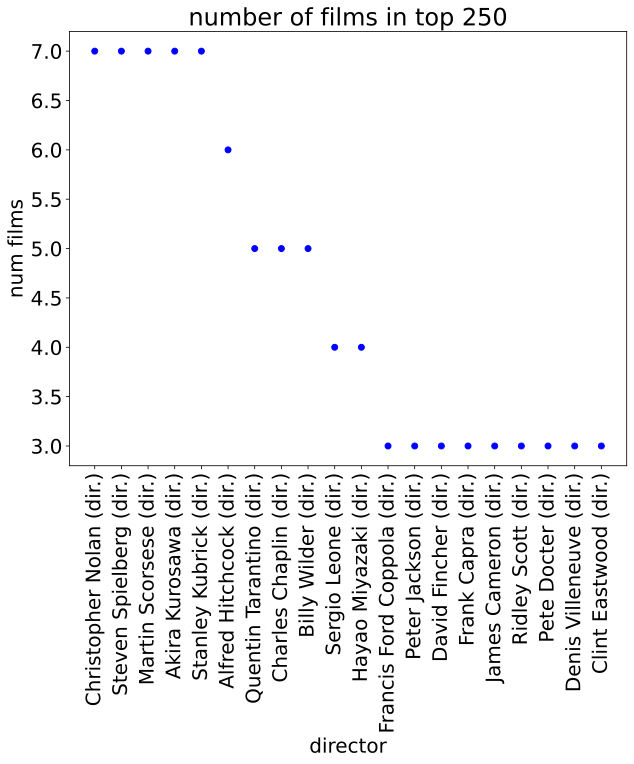

In [30]:
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # set font and plot size to be larger

plt.plot(dirs, num_films, "bo")
plt.title("number of films in top 250")
plt.xlabel("director")
plt.xticks(rotation = 90)
plt.ylabel("num films")

Задача 3. Найти участника(ов) команд, у которого(ых) больше всего фильмов в топе.

In [13]:
all_names = {}

for s in data.crew.values:
    for name in s.split(", "):
        if not name.endswith(" (dir.)"):
            if name in all_names:
                all_names[name] += 1
            else:
                all_names[name] = 1
    
all_names_list = sorted([(k, v) for k, v in all_names.items()], key=lambda x: -x[1])
print(all_names_list[:20])

member = [x[0] for x in all_names_list[:20]]
num_films = [x[1] for x in all_names_list[:20]]

[('Robert De Niro', 9), ('Tom Hanks', 6), ('Harrison Ford', 6), ('Christian Bale', 5), ('Clint Eastwood', 5), ('Leonardo DiCaprio', 5), ('Charles Chaplin', 5), ('Al Pacino', 4), ('Brad Pitt', 4), ('Toshirô Mifune', 4), ('James Stewart', 4), ('Matt Damon', 4), ('Marlon Brando', 3), ('Henry Fonda', 3), ('Elijah Wood', 3), ('Mark Hamill', 3), ('Jack Nicholson', 3), ('Anthony Hopkins', 3), ('Russell Crowe', 3), ('Kevin Spacey', 3)]


Text(0, 0.5, 'num films')

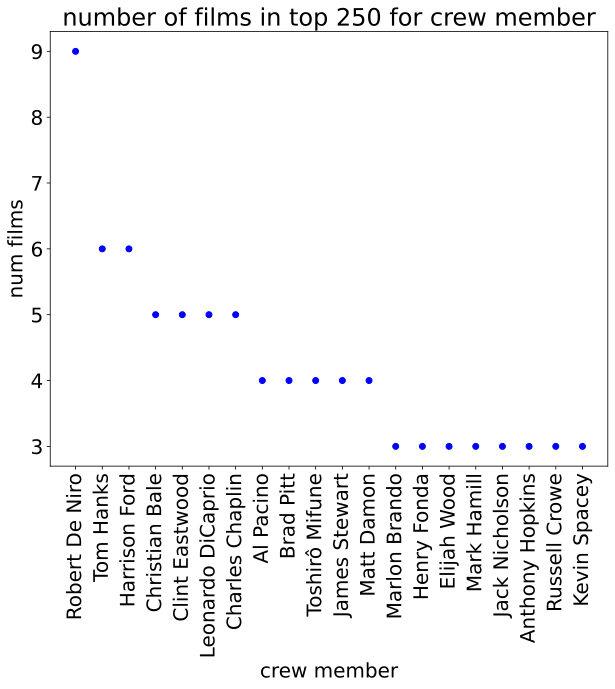

In [14]:
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # set font and plot size to be larger

plt.plot(member, num_films, "bo")
plt.title("number of films in top 250 for crew member")
plt.xlabel("crew member")
plt.xticks(rotation = 90)
plt.ylabel("num films")

Задача 4. Построить распределение топовых фильмов по годам

In [15]:
films_year = {}

for year in data.year.values:
    if year in films_year:
        films_year[year] += 1
    else:
        films_year[year] = 1
    
films_year_list = sorted([(k, v) for k, v in films_year.items()], key=lambda x: x[0])

year = [x[0] for x in films_year_list]
num_films = [x[1] for x in films_year_list]

Text(0, 0.5, 'num films')

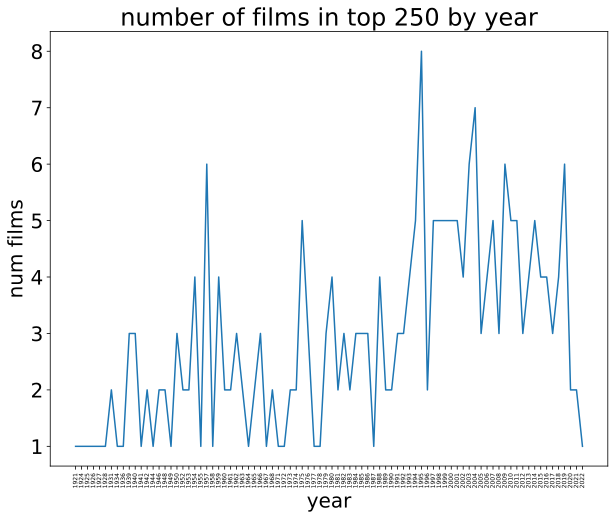

In [16]:
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # set font and plot size to be larger

plt.plot(year, num_films)
plt.title("number of films in top 250 by year")
plt.xlabel("year")
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=6)
plt.ylabel("num films")

Задача 5. Построить распределение топовых фильмов рейтингу:


*   Округлить до сотых и отрисовать
*   Округлить до десятых и отрисовать
*   Округлить до целых и отрисовать

In [48]:
def get_distr(arr, precision):
    tmp = {}
    res = []
    for val in arr:
        val = round(float(val), precision)
        if val in tmp:
            tmp[val] += 1
        else:
            tmp[val] = 1

    tmp_list = sorted([(k, v) for k, v in tmp.items()], key=lambda x: x[0])

    vals = [x[0] for x in tmp_list]
    height = [x[1] for x in tmp_list]
    return vals, height

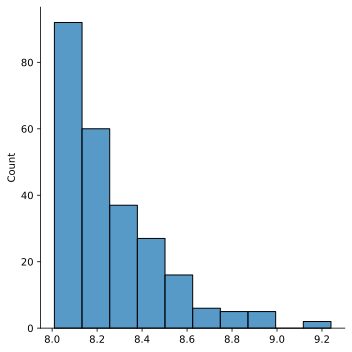

In [76]:
# Округлить до сотых и отрисовать
sns.displot([round(float(x), 2) for x in data['ratings'].values], bins=10)

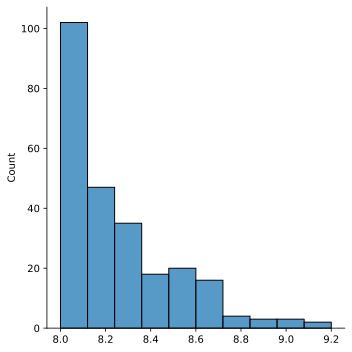

In [77]:
# Округлить до десятых и отрисовать
sns.displot([round(float(x), 1) for x in data['ratings'].values], bins=10)

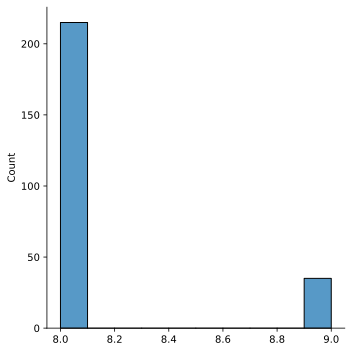

In [78]:
# Округлить до десятых и отрисовать
sns.displot([round(float(x), 0) for x in data['ratings'].values], bins=10)

Задача 6. Используйте ссылку `http://www.imdb.com/` и динамически добавляя ссылку на фильм из колонки `links` соберите описание фильмов. Пример поиска необходимого текст представлен ниже. Добавьте эту информацию в исходный датафрейм.

In [79]:
film_url = 'http://www.imdb.com/title/tt0068646/'
html_text = requests.get(film_url).text

In [80]:
soup = BeautifulSoup(html_text, 'lxml')
soup.find_all(attrs={"name": "description"})[0].get("content")

'Крёстный отец: Directed by Francis Ford Coppola. With Marlon Brando, Al Pacino, James Caan, Richard S. Castellano. The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.'

In [81]:
def get_description(link):
    film_url = 'http://www.imdb.com' + link
    html_text = requests.get(film_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    return soup.find_all(attrs={"name": "description"})[0].get("content")

In [82]:
film_url = 'http://www.imdb.com/title/tt0068646/'
html_text = requests.get(film_url).text
soup = BeautifulSoup(html_text, 'lxml')
soup.find_all(attrs={"name": "description"})

[<meta content="Крёстный отец: Directed by Francis Ford Coppola. With Marlon Brando, Al Pacino, James Caan, Richard S. Castellano. The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son." data-id="main" name="description"/>]

In [83]:
from tqdm import tqdm

arr = []

for i in tqdm(data.links.values):
    arr.append(get_description(i))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [07:25<00:00,  1.78s/it]


In [84]:
data["description"] = arr

In [85]:
data.head()

,movies,ratings,crew,links,title,year,description
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.239990361473694,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994,Побег из Шоушенка: Directed by Frank Darabont....
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.160997117810007,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972,Крёстный отец: Directed by Francis Ford Coppol...
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993872535873475,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008,Темный рыцарь: Directed by Christopher Nolan. ...
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.99010819442431,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974,Крёстный отец 2: Directed by Francis Ford Copp...
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950785755799387,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957,12 рaзгневанных мужчин: Directed by Sidney Lum...


Задача 7. С помощью регулярных выражений найдите в текстах описания фильмов имена актеров, если это возможно (то есть - они там упоминаются). Добавьте эту информацию в датафрейм и посчитайте, для скольких фильмов получилось это сдлеать. Подсказка: перечисление актеров иногда начинается с with. 

In [86]:
def get_crew(s):
    s.replace("With", "with")
    finded = re.findall(r'(?<=with )[^.]+', s)
    if len(finded) > 0:
        return finded[0]
    else:
        return ""


In [87]:
data["my_crew"] = data["description"].apply(get_crew)
data.head()

,movies,ratings,crew,links,title,year,description,my_crew
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.239990361473694,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994,Побег из Шоушенка: Directed by Frank Darabont....,
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.160997117810007,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972,Крёстный отец: Directed by Francis Ford Coppol...,
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993872535873475,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008,Темный рыцарь: Directed by Christopher Nolan. ...,
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.99010819442431,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974,Крёстный отец 2: Directed by Francis Ford Copp...,
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950785755799387,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957,12 рaзгневанных мужчин: Directed by Sidney Lum...,


In [88]:
finded_crew = len([x for x in data["my_crew"].values if len(x) > 5])
print(f"Non empty crew: {finded_crew}")

Non empty crew: 53


Актёры выделены почти из всех описаний, но с разным качеством, так как брал строку, начинающуюся с With/with до первой точки.

Задача 8. Распарсите исходную страницу с топ-250 фильмов и получите для каждого фильмов количество оценок. Пример текста в исходной странице:`9.2 based on 2,554,919 user ratings`. Из этого текста нужно достать = `2,554,919`. Подсказка: используя метод `find_all` с аргументом `attrs` в который нужно передать `{'class': 'ratingColumn imdbRating'}` от страници `http://www.imdb.com/chart/top`. Найдите 10 фильмов (вывести их название и кол-во оценок) у которых, самое большое количество оценок.

In [89]:
def get_reviews():
    film_url = 'http://www.imdb.com/chart/top'
    html_text = requests.get(film_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    all_str = []
    for tag in soup.find_all(attrs={'class': 'ratingColumn imdbRating'}):
        s = tag.find("strong").get("title")
        digit = re.findall("(?<=on)(.*)(?=user)", s)
        all_str.append(int(digit[0].strip().replace(",", "")))
    return all_str

In [90]:
data["reviews"] = get_reviews()

In [91]:
data.head()

,movies,ratings,crew,links,title,year,description,my_crew,reviews
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.239990361473694,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994,Побег из Шоушенка: Directed by Frank Darabont....,,2563357
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.160997117810007,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972,Крёстный отец: Directed by Francis Ford Coppol...,,1764257
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993872535873475,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008,Темный рыцарь: Directed by Christopher Nolan. ...,,2525322
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.99010819442431,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974,Крёстный отец 2: Directed by Francis Ford Copp...,,1221404
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950785755799387,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957,12 рaзгневанных мужчин: Directed by Sidney Lum...,,757139


Найдите 10 фильмов (вывести их название и кол-во оценок) у которых, самое большое количество оценок:

In [32]:
data[["title", "reviews"]].sort_values("reviews", ascending=False)[:10]

,title,reviews
0,Побег из Шоушенка,2562524
2,Темный рыцарь,2524041
12,Начало,2249530
11,Бойцовский клуб,2016563
10,Форрест Гамп,1976864
7,Криминальное чтиво,1968055
15,Матрица,1845663
8,Властелин колец: Братство кольца,1785834
6,Властелин колец: Возвращение короля,1764010
1,Крёстный отец,1763704


Задача 9. Постройте топ 10 слов, которые встречаются 

1.   в названии фильмов
2.   в описании фильмов
3.   в названии и в описании фильмов

In [33]:
# в названии фильмов
films_title = {}

for title in data.title.values:
    for word in title.lower().split():
        if word in films_title:
            films_title[word] += 1
        else:
            films_title[word] = 1
    
films_title_list = sorted([(k, v) for k, v in films_title.items()], key=lambda x: -x[1])
films_title_list[:10]

[('в', 11),
 ('и', 9),
 ('на', 8),
 ('отец', 4),
 ('по', 4),
 ('властелин', 3),
 ('колец:', 3),
 ('звёздные', 3),
 ('войны.', 3),
 ('эпизод', 3)]

In [34]:
# в описании фильмов
films_descr = {}

for title in data.description.values:
    for word in title.lower().split():
        if word in films_descr:
            films_descr[word] += 1
        else:
            films_descr[word] = 1
    
films_descr_list = sorted([(k, v) for k, v in films_descr.items()], key=lambda x: -x[1])
films_descr_list[:10]

[('a', 383),
 ('the', 365),
 ('with', 314),
 ('by', 294),
 ('directed', 250),
 ('to', 232),
 ('of', 206),
 ('and', 179),
 ('in', 152),
 ('his', 146)]

In [35]:
# в названии и в описании фильмов
films = {}

for title in data.title.values:
    for word in title.lower().split():
        if word in films:
            films[word] += 1
        else:
            films[word] = 1

for title in data.description.values:
    for word in title.lower().split():
        if word in films:
            films[word] += 1
        else:
            films[word] = 1

films_list = sorted([(k, v) for k, v in films.items()], key=lambda x: -x[1])
films_list[:10]

[('a', 384),
 ('the', 368),
 ('with', 314),
 ('by', 294),
 ('directed', 250),
 ('to', 235),
 ('of', 207),
 ('and', 179),
 ('in', 152),
 ('his', 146)]

Задача 10*. Спарсить теги фильмов со страницы каждого фильма, так например для `The Godfather` ожидается получить список из `Crime, Drama`. (Можно увидеть эти теги по картинкой к фильму)

In [36]:
def get_genres(link):
    film_url = 'http://www.imdb.com' + link
    html_text = requests.get(film_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    tmp = soup.find_all(attrs={"class": "ipc-chip__text"})
    return [x.string for x in tmp if x.string[0].isupper()]

In [37]:
data["genre"] = data["links"].apply(get_genres)

In [38]:
data.head()

,movies,ratings,crew,links,title,year,description,my_crew,reviews,genre
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.240019142733797,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994,Побег из Шоушенка: Directed by Frank Darabont....,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2562524,[Drama]
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.160961594083062,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972,Крёстный отец: Directed by Francis Ford Coppol...,"Marlon Brando, Al Pacino, James Caan, Richard S",1763704,"[Crime, Drama]"
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993793904363804,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008,Темный рыцарь: Directed by Christopher Nolan. ...,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2524041,"[Action, Crime, Drama]"
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990083469380808,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974,Крёстный отец 2: Directed by Francis Ford Copp...,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",1221127,"[Crime, Drama]"
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.95072817577575,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957,12 рaзгневанных мужчин: Directed by Sidney Lum...,"Martin Balsam, John Fiedler, Lee J",756935,"[Crime, Drama]"
